In [1]:
#!unzip dank_data-master.zip
#!pip install tensorflow_addons

In [2]:
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,Embedding,LSTM,concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import logging
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
training='/content/dank_data-master/data/training/*'
test='/content/dank_data-master/data/test/*'
validation='/content/dank_data-master/data/validation/*'

In [4]:
training = glob.glob(training)
test = glob.glob(test)
validation = glob.glob(validation)

In [5]:
final_dank=pd.read_csv('/content/dank_data-master/data/final_dank.csv')
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in training]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation]
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test]

In [6]:
for labels in train_labels:
    if labels==train_labels[0]:
        train_data =final_dank[final_dank['id']==labels]
    else :
        train_data =train_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in validation_labels:
    if labels==validation_labels[0]:
        val_data =final_dank[final_dank['id']==labels]
    else :
        val_data =val_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in test_labels:
    if labels==test_labels[0]:
        test_data =final_dank[final_dank['id']==labels]
    else :
        test_data =test_data.append(final_dank[final_dank['id']==labels],sort=False)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
train_data.head(5)

(3405, 68)
(1719, 68)
(1688, 68)


,Unnamed: 0,level_0,index,author,awards,processed_words,created_utc,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,datetime_temp,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob,vgg_feature_1,vgg_feature_2,vgg_feature_3
53606,96606,1118.0,32771.0,SwiftScout4,[],['dowk'],1.584914e+09,0.0,fn7zmy,False,https://i.redd.it/5wyri1k2pao41.jpg,r/memes,10674286.0,91.0,default,140.0,Yep,1.0,/r/memes/comments/fn7zmy/yep/,2020-03-22 16:50:48,3.0,9.368308e-08,0.0,63.0,0.45,1.0,154.090061,177.049433,14.463780,207.352720,66.871711,207.413170,0.026705,0.000000,0.0,0.003908,0.0,0.035172,0.095747,0.020192,0.078812,1.351533,0.001303,0.0,0.0,0.0,0.0,0.00000,0.000000,0.087280,0.005862,0.0,0.0,0.0,0.0,0.906015,0.0,0.0,0.0,0.0,1.351533,0.556245,0.429849,0.109972,0.065715,hammer,hatchet,hand_blower
35469,61068,63931.0,63931.0,Captain_Trisl,[],"['boy', 'hang', 'quarantinel', 'orona', 'extra']",1.584168e+09,0.0,fieaah,False,https://i.redd.it/u1hohc4n2lm41.jpg,r/memes,9552928.0,70.0,https://b.thumbs.redditmedia.com/iizmg3kqOI6Vx...,140.0,Me and the boys hanging out during quarantine,26.0,/r/memes/comments/fieaah/me_and_the_boys_hangi...,2020-03-14 01:36:23,0.0,2.721679e-06,0.0,59.0,0.49,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11453,25253,26477.0,26477.0,Kenmoops,[],"['vehe', 'believ', 'lie', 'girl']",1.584383e+09,0.0,fjpm7n,False,https://i.redd.it/4yuywm16u2n41.jpg,r/memes,9552828.0,140.0,https://b.thumbs.redditmedia.com/n-eFw_VxX9qgw...,140.0,S be ve,28.0,/r/memes/comments/fjpm7n/s_be_ve/,2020-03-16 13:20:58,3.0,2.931069e-06,0.0,55.0,0.46,4.0,174.131270,121.785332,109.635359,118.092869,154.038706,201.257626,0.665387,0.022622,0.0,0.018721,0.0,0.294861,0.000000,0.105307,0.000000,0.000000,0.085806,0.0,0.0,0.0,0.0,12.18992,0.028862,0.022622,0.058504,0.0,0.0,0.0,0.0,0.010921,0.0,0.0,0.0,0.0,0.000000,0.001560,0.589724,0.049609,0.047696,lab_coat,pajama,stethoscope
53276,96125,621.0,32274.0,fantastich_freidrich,[],"['human', 'come', 'futuretim', 'travel', 'trap...",1.584917e+09,0.0,fn8ult,False,https://i.redd.it/k3nqe069yao41.jpg,r/memes,10674284.0,135.0,https://b.thumbs.redditmedia.com/1_VRahW76_09S...,140.0,"Humanity won’t die, he is coming from future",50.0,/r/memes/comments/fn8ult/humanity_wont_die_he_...,2020-03-22 17:42:17,4.0,4.684155e-06,0.0,146.0,0.40,10.0,118.162830,146.873249,12.181125,181.512199,111.588219,182.762448,1.425067,0.000000,0.0,3.873203,0.0,4.176264,0.058710,0.022288,1.116026,0.777902,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,1.262256,3.166513,0.0,0.0,0.0,0.0,52.835110,0.0,0.0,0.0,0.0,0.777902,0.078279,0.365487,0.057522,0.045649,remote_control,bathtub,washbasin
65568,129029,4832.0,66485.0,YashSSJB1,[],"['centr', 'attractionm', 'show', 'fulli', 'bui...",1.584688e+09,0.0,flqn9e,False,https://i.redd.it/qu5nr0tj1sn41.jpg,r/memes,10674380.0,140.0,https://a.thumbs.redditmedia.com/nHhkqeC5ANrGn...,140.0,Centre of attraction,8625.0,/r/memes/comments/flqn9e/centre_of_attraction/,2020-03-20 02:06:54,0.0,8.080095e-04,1.0,119.0,0.57,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def file_extension(x):
      return x+".jpg"
train_data['id'] = train_data['id'].apply(file_extension)
val_data['id'] = val_data['id'].apply(file_extension)
test_data['id'] = test_data['id'].apply(file_extension)

In [8]:
def numeric_to_string(x):
    if (x==1.0):
        return 'Not_dank'
    elif (x==0.0):
        return 'Dank'
train_data['dank_level_new'] = train_data['dank_level'].apply(numeric_to_string)
val_data['dank_level_new'] = val_data['dank_level'].apply(numeric_to_string)
test_data['dank_level_new'] = test_data['dank_level'].apply(numeric_to_string)

In [9]:
  logger = logging.getLogger()
  logger.disabled = False  
  train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                    horizontal_flip=True, fill_mode='nearest')
  train_generator = train_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              subset="training",
              batch_size=30,
              seed=42,
              class_mode="binary",
              target_size= (156,156))
  predict_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  train_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              class_mode="binary",
              shuffle=False,
              target_size= (156,156))
  validation_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=val_data,
              directory="/content/dank_data-master/data/validation/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (156,156))
  test_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=test_data,
              directory="/content/dank_data-master/data/test/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (156,156))

Found 3405 validated image filenames belonging to 2 classes.
Found 3405 validated image filenames belonging to 2 classes.
Found 1688 validated image filenames belonging to 2 classes.
Found 1719 validated image filenames belonging to 2 classes.


In [10]:
IMAGE_SIZE = [156,156]
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [11]:
for layer in vgg19.layers[:11]:
    layer.trainable = False

In [12]:
#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(vgg19.output)

#FC layer
FC1 = Dense(units=512,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)
x = Dropout(0.3)(FC1)
#FC layer
FC2 = Dense(units=256,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(x)
x = Dropout(0.3)(FC2)
#FC layer
FC3 = Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC3')(x)
x = Dropout(0.3)(FC3)
#FC layer
FC4 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC4')(x)
x = Dropout(0.3)(FC4)

#output layer
Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(x)

model = Model(inputs=vgg19.input, outputs=Out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 156, 156, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 156, 156, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 156, 156, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 78, 78, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 78, 78, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 78, 78, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 39, 39, 128)       0     

In [13]:
def scheduler(epoch,lr):
    if((epoch+1)%3==0):
        lr=lr*0.95
        return lr
    else:
        return lr

In [14]:

filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=3,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=3, min_lr=0.001,verbose=1)

model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=1)]
)


In [15]:
history=model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=50,validation_data=test_prediction_generator,validation_steps=len(test_prediction_generator),use_multiprocessing=False,workers=12,callbacks=[lrschedule,checkpoint,reduce_lr])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 131s 810ms/step - loss: 2.2119 - accuracy: 0.4931 - precision: 0.4879 - recall: 0.5281 - f1_score: 0.6626 - val_loss: 0.6949 - val_accuracy: 0.5073 - val_precision: 0.4923 - val_recall: 0.6149 - val_f1_score: 0.6518
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 94s 764ms/step - loss: 0.7076 - accuracy: 0.5027 - precision: 0.4992 - recall: 0.5333 - f1_score: 0.6631 - val_loss: 0.6934 - val_accuracy: 0.5119 - val_precision: 0.4961 - val_recall: 0.6101 - val_f1_score: 0.6518
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.499999760009813e-06.
114/114 [==============================] - 97s 786ms/step - loss: 0.6972 - accuracy: 0.4838 - precision: 0.5035 - recall: 0.4390 - f1_score: 0.6833 - val_loss: 0.6937 - val_accuracy: 0.4887 - val

In [18]:
model_checkpoint =  Model(inputs=vgg19.input, outputs=Out)
model_checkpoint.load_weights('/content/model_save/weights-01-0.5073.h5')
model_checkpoint.save('bestmodel_vgg19.h5')
new_model = tf.keras.models.load_model('bestmodel_vgg19.h5')

In [19]:
test_prediction=new_model.predict_generator(test_prediction_generator,steps=len(test_prediction_generator),workers=12)
test_prediction=((test_prediction > 0.5)+0).ravel() 
print(test_prediction.shape)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test=np.argmax(y_test,axis=-1)
y_test.shape

(1719,)


(1719,)

Test accuracy_score 0.5072716695753345
Test F1_score 0.5468164794007491
Test confusion matrix


Text(0.5, 15.0, 'Predicted label')

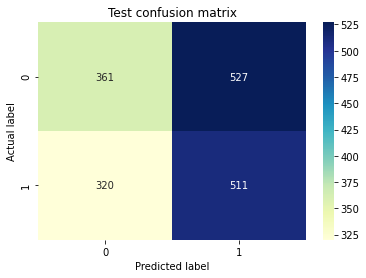

In [20]:
accuracy=accuracy_score(y_test,test_prediction)
print("Test accuracy_score",accuracy)
f1_test_score=f1_score(y_test,test_prediction)
print("Test F1_score",f1_test_score)
print("Test confusion matrix")
cnf_matrix2=confusion_matrix(y_test,test_prediction)
p = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Test confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

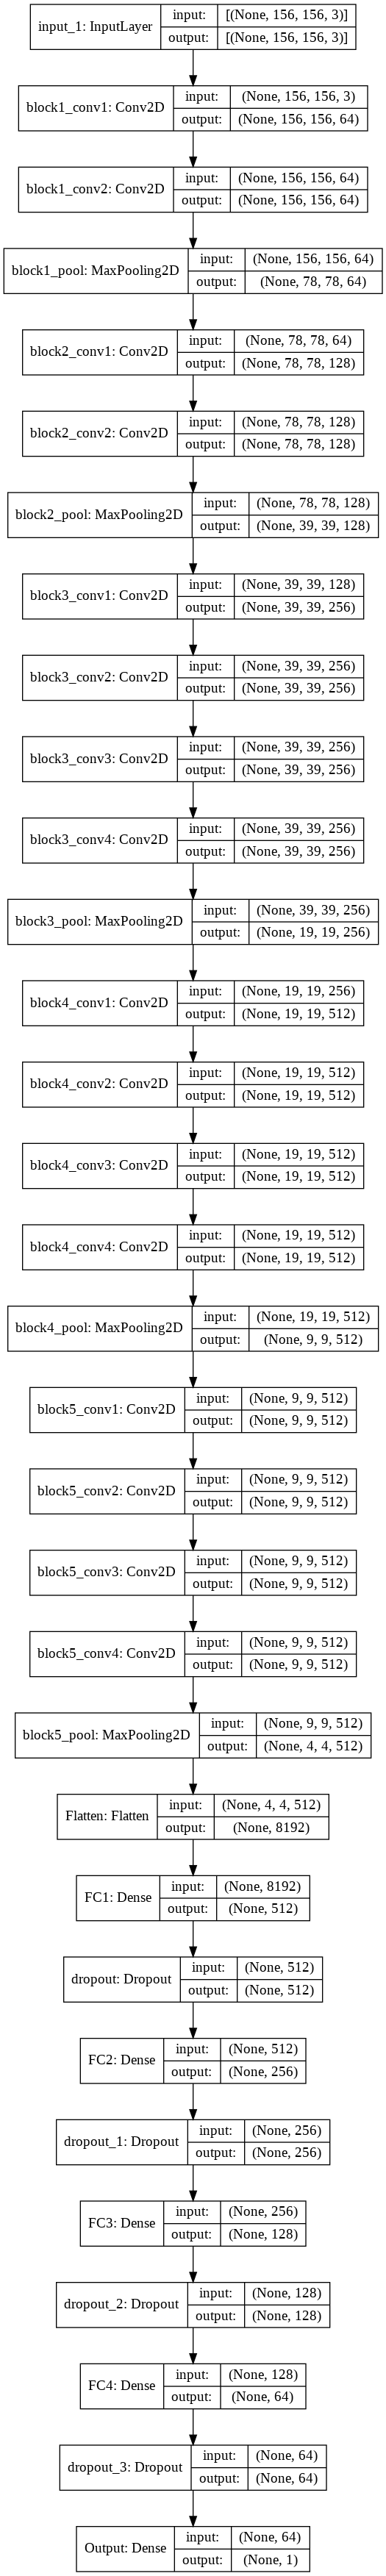

In [21]:
file = '/content/model_1.png'
tf.keras.utils.plot_model(model,to_file=file, show_shapes=True)